# Model and Data Download

In [ ]:
# Change the paths as you need
!mkdir /content/models
!mkdir /content/models/vgg16
!mkdir /content/models/alexnet
!wget https://download.pytorch.org/models/vgg16-397923af.pth -O /content/models/vgg16/model.pth
!wget https://download.pytorch.org/models/alexnet-owt-7be5be79.pth -O /content/models/alexnet/model.pth

In [ ]:
!mkdir /content/models/resnet
!wget https://download.pytorch.org/models/resnet50-0676ba61.pth -O /content/models/resnet/model.pth

In [ ]:
#Optional you can get images from anywhere you want
!wget https://codeload.github.com/EliSchwartz/imagenet-sample-images/zip/refs/heads/master -O sample_images.zip
!unzip sample_images.zip

# Load Input Image

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

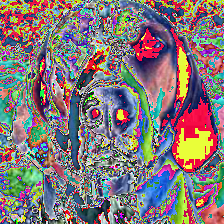

In [ ]:
from PIL import Image,ImageEnhance
from torchvision import transforms
input_image = Image.open('test_image.jpg')#('/content/Images/n02089867-Walker_hound/n02089867_1105.jpg')
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Try with and without normalizing
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)
transforms.ToPILImage()(input_batch[0]).convert("RGB")

# Deconv Wrapper Class

In [ ]:
class Deconv(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.model = model
    self.layer_counter = 0
    self.pass_forward = 0

  def forward_one_layer(self,x,indices):
    # print('At layer ',self.layer_counter)
    layer, rev_layer = self.model.features[self.layer_counter],self.model.rev_features[self.layer_counter]
    if layer._get_name()=='MaxPool2d':
      y,switches = layer(x)
    else:
      y,switches = layer(x),None
    
    
    back_input=[]
    for ind in indices:
      new_y = y[0].detach().clone()
      new_y = torch.stack([i if index==ind else torch.zeros_like(i) for index,i in enumerate(new_y)],axis=0)
      back_input.append(new_y)
    back_input = torch.stack(back_input,axis=0)

    if self.pass_forward==0:
      if switches is not None:
        switches = switches[0].repeat(len(indices),1,1,1)
        return rev_layer(back_input,switches)
      return rev_layer(back_input)
    
    self.layer_counter+=1
    self.pass_forward-=1
    propogating_back_input = self.forward_one_layer(y,indices)

    total_back_input = torch.cat([back_input,propogating_back_input],axis = 0)
    if switches is not None:
      switches = switches[0].repeat(total_back_input.shape[0],1,1,1)
      return rev_layer(total_back_input,switches)
    return rev_layer(total_back_input)

      
  def forward(self,x,num_layers = 1,indices = None):
    self.pass_forward = num_layers -1
    self.layer_counter = 0
    with torch.no_grad():
      viss = self.forward_one_layer(x,indices)
    return viss.cpu()
    plt.figure(figsize=(20,10))
    for i,vis in enumerate(viss):
      plt.subplot(3,6,i+1)
      # Try out various clipping/normalization methods
      vis_mean = transforms.ToPILImage()(vis.clamp(min=0)).convert("RGB")
      # ToDo try out various enhancing methods
      enhancer = ImageEnhance.Contrast(vis_mean)
      factor = 2
      enh_vis_mean = enhancer.enhance(factor)
      plt.imshow(enh_vis_mean)
      plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
# dvgg = Deconv(vgg16)
# dvgg(input_batch,1)

# VGG 16 (without batch normalization)

In [ ]:
%run vgg.py

In [ ]:


def get_input_image(filename='test_image.jpg'):
  input_image = Image.open(filename)#('/content/Images/n02089867-Walker_hound/n02089867_1105.jpg')
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  # Try with and without normalizing
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  return input_batch
import os
all_files =[]
for i,j,k in os.walk('/content/imagenet-sample-images-master'):
  for file in k:
    if file.endswith('.JPEG'):
      all_files.append(i+'/'+file)


from tqdm import tqdm
max_num = 9
num_layers = 5
class topk():
  def __init__(self,k=9):
    self.keys = [-1 for i in range(k)]
    self.cmp_order = np.argsort(self.keys)
    self.values = [None for i in range(k)]
    self.ims = [None for i in range(k)]
  def add(self,element,im):
    curr_key = np.abs(element.norm())
    self.min = np.argmin(self.keys)
    for i in self.cmp_order:
      if self.keys[i]<=curr_key:
        self.keys[i]=curr_key
        self.values[i] = element
        self.ims[i] = im
        break
    self.cmp_order = np.argsort(self.keys)

In [ ]:
dvgg = Deconv(vgg16)
indices = np.arange(0,27,3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dvgg.to(device)

# for i in range(1,11):
#   indices = np.arange(0,27,3)
#   print('Activations and Features at layer ',i)
#   dvgg(input_batch,i,indices)

In [ ]:
class topk():
  def __init__(self,k=9):
    self.keys = [-1 for i in range(k)]
    self.cmp_order = np.argsort(self.keys)
    self.values = [None for i in range(k)]
    self.ims = [None for i in range(k)]
  def add(self,element,im):
    curr_key = np.abs(element.norm())
    self.min = np.argmin(self.keys)
    for i in self.cmp_order:
      if self.keys[i]<=curr_key:
        self.keys[i]=curr_key
        self.values[i] = element
        self.ims[i] = im
        break
    self.cmp_order = np.argsort(self.keys)







all_visses = [topk(max_num) for i in range(num_layers*len(indices))]
rem_files = []
for i in tqdm(all_files):
  try:
    input_batch = get_input_image(i)
    inp = transforms.ToPILImage()(input_batch[0]).convert("RGB")
    input_batch = input_batch.to(device)
    visses = dvgg(input_batch,num_layers,indices)
    # print(visses[13].norm())
  except :
    print('File ',i,' is not proper')
    rem_files.append(i)
    continue
  [top.add(curr,inp) for curr,top in zip(visses,all_visses)]


  6%|▌         | 62/1000 [00:11<02:17,  6.81it/s]

File  /content/imagenet-sample-images-master/n03692522_loupe.JPEG  is not proper


 13%|█▎        | 134/1000 [00:25<02:08,  6.76it/s]

File  /content/imagenet-sample-images-master/n03417042_garbage_truck.JPEG  is not proper


 16%|█▋        | 163/1000 [00:31<02:09,  6.46it/s]

File  /content/imagenet-sample-images-master/n03992509_potter's_wheel.JPEG  is not proper


 20%|██        | 202/1000 [00:38<02:00,  6.63it/s]

File  /content/imagenet-sample-images-master/n04554684_washer.JPEG  is not proper


 21%|██        | 212/1000 [00:40<01:59,  6.58it/s]

File  /content/imagenet-sample-images-master/n03873416_paddle.JPEG  is not proper


 24%|██▍       | 241/1000 [00:45<01:52,  6.76it/s]

File  /content/imagenet-sample-images-master/n04371774_swing.JPEG  is not proper


 26%|██▌       | 256/1000 [00:48<02:31,  4.91it/s]

File  /content/imagenet-sample-images-master/n02676566_acoustic_guitar.JPEG  is not proper


 38%|███▊      | 381/1000 [01:12<01:33,  6.60it/s]

File  /content/imagenet-sample-images-master/n03764736_milk_can.JPEG  is not proper


 55%|█████▌    | 554/1000 [01:45<01:06,  6.69it/s]

File  /content/imagenet-sample-images-master/n03804744_nail.JPEG  is not proper


 59%|█████▉    | 591/1000 [01:52<01:00,  6.74it/s]

File  /content/imagenet-sample-images-master/n04356056_sunglasses.JPEG  is not proper


 60%|██████    | 604/1000 [01:55<01:01,  6.48it/s]

File  /content/imagenet-sample-images-master/n04008634_projectile.JPEG  is not proper


 64%|██████▎   | 636/1000 [02:01<00:53,  6.75it/s]

File  /content/imagenet-sample-images-master/n02749479_assault_rifle.JPEG  is not proper


 68%|██████▊   | 676/1000 [02:08<00:48,  6.71it/s]

File  /content/imagenet-sample-images-master/n03908714_pencil_sharpener.JPEG  is not proper


 69%|██████▉   | 694/1000 [02:11<00:46,  6.64it/s]

File  /content/imagenet-sample-images-master/n03388043_fountain.JPEG  is not proper


 70%|██████▉   | 697/1000 [02:12<00:41,  7.38it/s]

File  /content/imagenet-sample-images-master/n04372370_switch.JPEG  is not proper


 71%|███████   | 711/1000 [02:14<00:43,  6.67it/s]

File  /content/imagenet-sample-images-master/n02692877_airship.JPEG  is not proper


 75%|███████▍  | 747/1000 [02:21<00:38,  6.61it/s]

File  /content/imagenet-sample-images-master/n02815834_beaker.JPEG  is not proper


 76%|███████▌  | 762/1000 [02:24<00:35,  6.75it/s]

File  /content/imagenet-sample-images-master/n02096051_Airedale.JPEG  is not proper


 81%|████████▏ | 813/1000 [02:33<00:28,  6.65it/s]

File  /content/imagenet-sample-images-master/n04532670_viaduct.JPEG  is not proper


 82%|████████▏ | 821/1000 [02:35<00:26,  6.77it/s]

File  /content/imagenet-sample-images-master/n03697007_lumbermill.JPEG  is not proper


 83%|████████▎ | 831/1000 [02:36<00:25,  6.69it/s]

File  /content/imagenet-sample-images-master/n04090263_rifle.JPEG  is not proper


 91%|█████████ | 909/1000 [02:51<00:13,  6.63it/s]

File  /content/imagenet-sample-images-master/n02823750_beer_glass.JPEG  is not proper


 94%|█████████▎| 935/1000 [02:56<00:09,  6.69it/s]

File  /content/imagenet-sample-images-master/n04254680_soccer_ball.JPEG  is not proper


100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]


In [ ]:
# for index,j in enumerate(all_visses):
#   print(index)
#   print([i.shape for i in j.values])
all_visses[13].values

In [ ]:
all_visses[0].values

for index,im in enumerate(all_visses):
  print(f'At layer {1+(index//len(indices))} feature map {index%len(indices)}')
  plt.figure(figsize=(12,12))
  for i,(vis,img) in enumerate(zip(im.values,im.ims)):
    plt.subplot(6,6,2*i+1)
    # Try out various clipping/normalization methods
    vis_mean = transforms.ToPILImage()(vis.clamp(min=0)).convert("RGB")
    # ToDo try out various enhancing methods
    enhancer = ImageEnhance.Contrast(vis_mean)
    factor = 2
    enh_vis_mean = enhancer.enhance(factor)
    plt.imshow(enh_vis_mean)
    plt.axis('off')

    plt.subplot(6,6,2*i+2)
    plt.imshow(img)
    plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

# alexnet

In [ ]:
%run alexnet.py

<Figure size 432x288 with 0 Axes>

In [ ]:
dan = Deconv(an)
indices = np.arange(0,27,3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
dan.to(device)

In [ ]:
max_num = 9
num_layers = 5
all_visses = [topk(max_num) for i in range(num_layers*len(indices))]
rem_files = []
for i in tqdm(all_files):
  try:
    input_batch = get_input_image(i)
    inp = transforms.ToPILImage()(input_batch[0]).convert("RGB")
    input_batch = input_batch.to(device)
    visses = dan(input_batch,num_layers,indices)
    # print(visses[13].norm())
  except :
    print('File ',i,' is not proper')
    rem_files.append(i)
    continue
  [top.add(curr,inp) for curr,top in zip(visses,all_visses)]

  6%|▌         | 62/1000 [00:08<01:40,  9.30it/s]

File  /content/imagenet-sample-images-master/n03692522_loupe.JPEG  is not proper


 13%|█▎        | 134/1000 [00:17<01:35,  9.08it/s]

File  /content/imagenet-sample-images-master/n03417042_garbage_truck.JPEG  is not proper


 16%|█▋        | 163/1000 [00:21<01:32,  9.05it/s]

File  /content/imagenet-sample-images-master/n03992509_potter's_wheel.JPEG  is not proper


 20%|██        | 202/1000 [00:26<01:27,  9.17it/s]

File  /content/imagenet-sample-images-master/n04554684_washer.JPEG  is not proper


 21%|██        | 212/1000 [00:27<01:21,  9.65it/s]

File  /content/imagenet-sample-images-master/n03873416_paddle.JPEG  is not proper


 24%|██▍       | 241/1000 [00:31<01:25,  8.92it/s]

File  /content/imagenet-sample-images-master/n04371774_swing.JPEG  is not proper


 26%|██▌       | 258/1000 [00:34<01:20,  9.22it/s]

File  /content/imagenet-sample-images-master/n02676566_acoustic_guitar.JPEG  is not proper


 38%|███▊      | 381/1000 [00:50<01:06,  9.32it/s]

File  /content/imagenet-sample-images-master/n03764736_milk_can.JPEG  is not proper


 55%|█████▌    | 554/1000 [01:13<00:47,  9.36it/s]

File  /content/imagenet-sample-images-master/n03804744_nail.JPEG  is not proper


 59%|█████▉    | 591/1000 [01:18<00:43,  9.44it/s]

File  /content/imagenet-sample-images-master/n04356056_sunglasses.JPEG  is not proper


 60%|██████    | 604/1000 [01:20<00:43,  9.15it/s]

File  /content/imagenet-sample-images-master/n04008634_projectile.JPEG  is not proper


 64%|██████▎   | 636/1000 [01:24<00:38,  9.52it/s]

File  /content/imagenet-sample-images-master/n02749479_assault_rifle.JPEG  is not proper


 68%|██████▊   | 676/1000 [01:29<00:33,  9.69it/s]

File  /content/imagenet-sample-images-master/n03908714_pencil_sharpener.JPEG  is not proper


 69%|██████▉   | 694/1000 [01:32<00:31,  9.59it/s]

File  /content/imagenet-sample-images-master/n03388043_fountain.JPEG  is not proper


 70%|██████▉   | 697/1000 [01:32<00:28, 10.45it/s]

File  /content/imagenet-sample-images-master/n04372370_switch.JPEG  is not proper


 71%|███████   | 711/1000 [01:34<00:30,  9.46it/s]

File  /content/imagenet-sample-images-master/n02692877_airship.JPEG  is not proper


 75%|███████▍  | 747/1000 [01:39<00:27,  9.29it/s]

File  /content/imagenet-sample-images-master/n02815834_beaker.JPEG  is not proper


 76%|███████▌  | 762/1000 [01:40<00:25,  9.48it/s]

File  /content/imagenet-sample-images-master/n02096051_Airedale.JPEG  is not proper


 81%|████████▏ | 813/1000 [01:47<00:21,  8.88it/s]

File  /content/imagenet-sample-images-master/n04532670_viaduct.JPEG  is not proper


 82%|████████▏ | 821/1000 [01:48<00:19,  9.33it/s]

File  /content/imagenet-sample-images-master/n03697007_lumbermill.JPEG  is not proper


 83%|████████▎ | 831/1000 [01:50<00:18,  9.15it/s]

File  /content/imagenet-sample-images-master/n04090263_rifle.JPEG  is not proper


 91%|█████████ | 909/1000 [02:00<00:09,  9.32it/s]

File  /content/imagenet-sample-images-master/n02823750_beer_glass.JPEG  is not proper


 94%|█████████▎| 935/1000 [02:03<00:06,  9.54it/s]

File  /content/imagenet-sample-images-master/n04254680_soccer_ball.JPEG  is not proper


100%|██████████| 1000/1000 [02:12<00:00,  7.54it/s]


In [ ]:
for index,im in enumerate(all_visses):
  print(f'At layer {1+(index//len(indices))} feature map {index%len(indices)}')
  plt.figure(figsize=(12,12))
  for i,(vis,img) in enumerate(zip(im.values,im.ims)):
    plt.subplot(6,6,2*i+1)
    # Try out various clipping/normalization methods
    vis_mean = transforms.ToPILImage()(vis.clamp(min=0)).convert("RGB")
    # ToDo try out various enhancing methods
    enhancer = ImageEnhance.Contrast(vis_mean)
    factor = 2
    enh_vis_mean = enhancer.enhance(factor)
    plt.imshow(enh_vis_mean)
    plt.axis('off')

    plt.subplot(6,6,2*i+2)
    plt.imshow(img)
    plt.axis('off')
  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

# ResNet 50
Deconvolution method is not described for skip connections and batch normalization hence using Vanilla Backprop instead

In [ ]:
%run resnet.py

## Backprop Wrapper Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from PIL import Image,ImageEnhance
from torchvision import transforms

def get_input_image(filename='test_image.jpg'):
  input_image = Image.open(filename)#('/content/Images/n02089867-Walker_hound/n02089867_1105.jpg')
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  # Try with and without normalizing
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  return input_batch
import os
all_files =[]
for i,j,k in os.walk('/content/imagenet-sample-images-master'):
  for file in k:
    if file.endswith('.JPEG'):
      all_files.append(i+'/'+file)


from tqdm import tqdm
max_num = 9
num_layers = 15
class topk():
  def __init__(self,k=9):
    self.keys = [-1 for i in range(k)]
    self.cmp_order = np.argsort(self.keys)
    self.values = [None for i in range(k)]
    self.ims = [None for i in range(k)]
  def add(self,element,im):
    element = element.cpu()
    curr_key = np.abs(element.norm())
    self.min = np.argmin(self.keys)
    for i in self.cmp_order:
      if self.keys[i]<=curr_key:
        self.keys[i]=curr_key
        self.values[i] = element
        self.ims[i] = im
        break
    self.cmp_order = np.argsort(self.keys)

In [ ]:
import random
# Hooks are a bit weird. Every time you make a change restart the notebook you don't need to download all the files everytime
class VanillaBackprop(nn.Module):
  def __init__(self,model,num_maps=9,threshold_for_vis=0):
    super().__init__()
    self.model = model
    self.layer_counter =0
    self.num_maps =9
    self.visses = []
    try:
      count=0
      for layer in self.model.features:
        if count>=num_layers:
            break
        if layer._get_name()=='Conv2d':
          count+=1
          print('Registering hook on ',layer)
          layer.register_forward_hook(self.hook)
    except:
      l = [module for module in self.model.modules() if type(module) != nn.Sequential]
      count=0
      for layer in l:
        if count>=num_layers:
          break
        if layer._get_name()=='Conv2d':
          count+=1
          print('Registering hook on ',layer)
          self.visses.append([topk(max_num) for i in range(self.num_maps)])
          layer.register_forward_hook(self.hook_wrapper(layer,layer.out_channels,self.visses[-1]))
  def hook_wrapper(self,layerr,total_maps,viss):
    # print('Wrapper called on ',layerr)
    indices = random.sample(list(range(total_maps)),self.num_maps)
    

    def hook(module, input, output):
      # print('Activations and Visualizations layer ',self.layer_counter+1,' module is ',module)
      # self.layer_counter+=1

      # plt.figure(figsize=(20,10))
      # for index,i in enumerate(ordered_indexes[-18:][::-1]): 
      #   plt.subplot(3,6,index+1)
      #   vis= transforms.ToPILImage()(output[0][i]).convert("RGB")
      #   enhancer = ImageEnhance.Contrast(vis)
      #   enh_vis = enhancer.enhance(2)
      #   plt.imshow(enh_vis,cmap='magma')
      #   plt.axis('off')
      # plt.show()
      # plt.figure(figsize=(20,10))
      for index,i in enumerate(indices):
        self.x.grad=None
        self.zero_grad()
        output[0][i].sum().backward(retain_graph=True)
        try:
          viss[index].add(self.x.grad[0],self.inp)
        except:
          import pdb;pdb.set_trace()
    return hook
      #   plt.subplot(3,6,index+1)
      #   # Try out various clipping/normalization methods
      #   vis= transforms.ToPILImage()(self.x.grad[0]).convert("RGB")
      #   enhancer = ImageEnhance.Contrast(vis)
      #   enh_vis = enhancer.enhance(2)
      #   plt.imshow(enh_vis)
      #   plt.axis('off')
      # plt.show()
    



  def forward(self,x,inp):
    self.layer_counter=0
    x.requires_grad=True
    self.x=x
    self.inp = inp
    
    return self.model(x)

In [ ]:
rn_backprop = VanillaBackprop(rn)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rn_backprop.to(device)
print('')

Registering hook on  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Registering hook on  Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Registering hook on  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Registering hook on  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook on  Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Registering hook on  Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Registering hook o

In [ ]:
rem_files = []
for i in tqdm(all_files):
  try:
    input_batch = get_input_image(i)
    inp = transforms.ToPILImage()(input_batch[0]).convert("RGB")
    input_batch = input_batch.to(device)
    _ = rn_backprop(input_batch,inp)
    # print(visses[13].norm())
  except Exception as e:
    print('File ',i,' is not proper')
    rem_files.append(i)
    continue


  6%|▌         | 60/1000 [01:00<15:35,  1.01it/s]

File  /content/imagenet-sample-images-master/n03692522_loupe.JPEG  is not proper


 13%|█▎        | 132/1000 [02:10<14:16,  1.01it/s]

File  /content/imagenet-sample-images-master/n03417042_garbage_truck.JPEG  is not proper


 16%|█▌        | 161/1000 [02:38<13:45,  1.02it/s]

File  /content/imagenet-sample-images-master/n03992509_potter's_wheel.JPEG  is not proper


 20%|██        | 200/1000 [03:15<13:10,  1.01it/s]

File  /content/imagenet-sample-images-master/n04554684_washer.JPEG  is not proper


 21%|██        | 210/1000 [03:24<12:46,  1.03it/s]

File  /content/imagenet-sample-images-master/n03873416_paddle.JPEG  is not proper


 24%|██▍       | 239/1000 [03:52<12:29,  1.02it/s]

File  /content/imagenet-sample-images-master/n04371774_swing.JPEG  is not proper


 26%|██▌       | 256/1000 [04:08<12:21,  1.00it/s]

File  /content/imagenet-sample-images-master/n02676566_acoustic_guitar.JPEG  is not proper


 38%|███▊      | 379/1000 [06:08<10:13,  1.01it/s]

File  /content/imagenet-sample-images-master/n03764736_milk_can.JPEG  is not proper


 55%|█████▌    | 552/1000 [08:58<07:23,  1.01it/s]

File  /content/imagenet-sample-images-master/n03804744_nail.JPEG  is not proper


 59%|█████▉    | 589/1000 [09:34<06:50,  1.00it/s]

File  /content/imagenet-sample-images-master/n04356056_sunglasses.JPEG  is not proper


 60%|██████    | 602/1000 [09:46<06:36,  1.00it/s]

File  /content/imagenet-sample-images-master/n04008634_projectile.JPEG  is not proper


 63%|██████▎   | 634/1000 [10:17<06:04,  1.00it/s]

File  /content/imagenet-sample-images-master/n02749479_assault_rifle.JPEG  is not proper


 67%|██████▋   | 674/1000 [10:56<05:24,  1.00it/s]

File  /content/imagenet-sample-images-master/n03908714_pencil_sharpener.JPEG  is not proper


 69%|██████▉   | 692/1000 [11:13<05:04,  1.01it/s]

File  /content/imagenet-sample-images-master/n03388043_fountain.JPEG  is not proper


 70%|██████▉   | 695/1000 [11:15<04:10,  1.22it/s]

File  /content/imagenet-sample-images-master/n04372370_switch.JPEG  is not proper


 71%|███████   | 709/1000 [11:28<04:49,  1.01it/s]

File  /content/imagenet-sample-images-master/n02692877_airship.JPEG  is not proper


 74%|███████▍  | 745/1000 [12:03<04:12,  1.01it/s]

File  /content/imagenet-sample-images-master/n02815834_beaker.JPEG  is not proper


 76%|███████▌  | 760/1000 [12:16<03:57,  1.01it/s]

File  /content/imagenet-sample-images-master/n02096051_Airedale.JPEG  is not proper


 81%|████████  | 811/1000 [13:06<03:07,  1.01it/s]

File  /content/imagenet-sample-images-master/n04532670_viaduct.JPEG  is not proper


 82%|████████▏ | 819/1000 [13:13<02:52,  1.05it/s]

File  /content/imagenet-sample-images-master/n03697007_lumbermill.JPEG  is not proper


 83%|████████▎ | 829/1000 [13:22<02:45,  1.03it/s]

File  /content/imagenet-sample-images-master/n04090263_rifle.JPEG  is not proper


 91%|█████████ | 907/1000 [14:38<01:32,  1.01it/s]

File  /content/imagenet-sample-images-master/n02823750_beer_glass.JPEG  is not proper


 93%|█████████▎| 933/1000 [15:03<01:06,  1.00it/s]

File  /content/imagenet-sample-images-master/n04254680_soccer_ball.JPEG  is not proper


100%|██████████| 1000/1000 [16:09<00:00,  1.03it/s]


In [ ]:
for layer_index,layer in enumerate(rn_backprop.visses):
  for map_index,map in enumerate(layer):
    print(f'At layer {layer_index} feature map {map_index}')
    plt.figure(figsize=(12,12))
    for i,(vis,img) in enumerate(zip(map.values,map.ims)):
      plt.subplot(6,6,2*i+1)
      vis_mean = transforms.ToPILImage()(vis.clamp(min=0)).convert("RGB")
      enhancer = ImageEnhance.Contrast(vis_mean)
      factor = 2
      enh_vis_mean = enhancer.enhance(factor)
      plt.imshow(enh_vis_mean)
      plt.axis('off')

      plt.subplot(6,6,2*i+2)
      plt.imshow(img)
      plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()